### Step 1: Load the packages

In [3]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
import warnings
warnings.filterwarnings(action="ignore")

### Step 2.1: Read the SQL code and execute the query that pulls the data

In [29]:
# Read the query
path = "G:/My Drive/APAC/Autopricing/Vendor Clustering Automation/loved_brands_pairwise_simulation_tool/data_extraction_query.sql"
f = open(file=path, mode="r")
query = f.read()
f.close()

# Instantiate a BQ client
client = bigquery.Client(project="logistics-data-staging-flat")
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Step 2.2: Run the query

In [30]:
client.query(query=query).result()

### Step 3.1: Pull the data from the generated tables

In [309]:
df = client\
    .query(query="""SELECT * FROM `dh-logistics-product-ops.pricing.asa_level_data_loved_brands_pairwise_simulation` ORDER BY entity_id, master_asa_id, is_lb_lm, tier_rank_master_asa""")\
    .to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████| 43137/43137 [00:02<00:00, 16227.79rows/s]


### Step 3.2: Change the data types of some columns

In [310]:
numeric_cols = [
       # Integer columns
       "master_asa_id",
       "vendor_count_caught_by_asa",
       "tier_rank_master_asa",
       "num_tiers_master_asa",
       "order_count_vendor_cluster_tt_fee_level",
       "order_count_vendor_cluster_level",
       "order_count_master_asa_level",
       "order_count_entity_level",
       "previous_order_count_vendor_cluster_tt_fee_level",
       
       # Float columns
       "fee",
       "min_tt_fee_master_asa_level",
       "df_revenue_local_vendor_cluster_tt_fee_level",
       "df_revenue_eur_vendor_cluster_tt_fee_level",
       "vendor_gmv_local_vendor_cluster_tt_fee_level",
       "vendor_gmv_eur_vendor_cluster_tt_fee_level",
       "gp_local_vendor_cluster_tt_fee_level",
       "gp_eur_vendor_cluster_tt_fee_level",
       "vendor_cluster_order_share_of_entity",
       "master_asa_order_share_of_entity",
       "df_revenue_local_vendor_cluster_level", "df_revenue_eur_vendor_cluster_level",
       "gmv_local_vendor_cluster_level", "gmv_eur_vendor_cluster_level", 
       "gp_local_vendor_cluster_level", "gp_eur_vendor_cluster_level",
       "previous_fee_vendor_cluster_tt_fee_level",
       "tier_elasticity_vendor_cluster_level"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

### Step 4.2: Flag the outlier elasticity values

In [311]:
# Create a list of grouping and aggregate variables. They will be used in several steps below
grouping_vars = ["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered", "is_lb_lm"]
agg_vars = [
    "vendor_count_caught_by_asa", "num_tiers_master_asa",
    "order_count_vendor_cluster_level", "order_count_master_asa_level", "order_count_entity_level", "vendor_cluster_order_share_of_entity", "master_asa_order_share_of_entity",
    "df_revenue_local_vendor_cluster_level", "df_revenue_eur_vendor_cluster_level",
    "gmv_local_vendor_cluster_level", "gmv_eur_vendor_cluster_level",
    "gp_local_vendor_cluster_level", "gp_eur_vendor_cluster_level"
]

# Filter for rows with non-null elasticity values
df_no_null_elasta = df.loc[df["tier_elasticity_vendor_cluster_level"].notnull(), :]

# Create a grouped object
df_grouped = df_no_null_elasta.groupby(grouping_vars, as_index=False)["tier_elasticity_vendor_cluster_level"]

df_q25_elasta = df_grouped.apply(np.percentile, q=25).rename(columns=dict(tier_elasticity_vendor_cluster_level= "q25")) # type: ignore
df_q75_elasta = df_grouped.apply(np.percentile, q=75).rename(columns=dict(tier_elasticity_vendor_cluster_level= "q75")) # type: ignore

# Join df_q25_elasta and df_q75_elasta to df
df = df\
    .merge(right=df_q25_elasta, on=grouping_vars, how="left")\
    .merge(right=df_q75_elasta, on=grouping_vars, how="left")

# Calculate the IQR, upper bound and lower bound
df["iqr"] = df["q75"] - df["q25"]
df["lower_bound"] = df["q25"] - 1.5 * df["iqr"]
df["upper_bound"] = df["q75"] + 1.5 * df["iqr"]
df["is_elasticity_remove"] = np.where(
    (np.isnan(df["tier_elasticity_vendor_cluster_level"])) | # If elasticity value is NaN
    (df["tier_elasticity_vendor_cluster_level"] < df["lower_bound"]) | # ... or below lower bound
    (df["tier_elasticity_vendor_cluster_level"] > df["upper_bound"]), # ... or above upper bound
    True, # Value of flag if the condition evaluates to True
    False # Value of flag if the condition evaluates to False
)

### Step 4.3: Remove the outlier elasticity values and calculate the average elasticity per vendor cluster

In [312]:
df_agg_elasticity = df[df["is_elasticity_remove"] == False]\
    .groupby(grouping_vars)["tier_elasticity_vendor_cluster_level"]\
    .agg(['median', 'mean'], axis=1)\
    .rename(columns={"median": "median_cluster_elasticity", "mean": "mean_cluster_elasticity"})\
    .reset_index()\

df = pd.merge(left = df, right=df_agg_elasticity, on=grouping_vars, how="left")

In [314]:
df.head(30)

,region,entity_id,country_code,master_asa_id,asa_common_name,is_asa_clustered,vendor_count_caught_by_asa,fee,tier_rank_master_asa,num_tiers_master_asa,...,previous_order_count_vendor_cluster_tt_fee_level,tier_elasticity_vendor_cluster_level,q25,q75,iqr,lower_bound,upper_bound,is_elasticity_remove,median_cluster_elasticity,mean_cluster_elasticity
0,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,0.39,1,5,...,<NA>,NaN,-2.919063,4.390475,7.309537,-13.883369,15.354781,True,-2.736815,-2.584366
1,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,0.49,2,5,...,2012,-3.465805,-2.919063,4.390475,7.309537,-13.883369,15.354781,False,-2.736815,-2.584366
2,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,1.99,3,5,...,224,22.213333,-2.919063,4.390475,7.309537,-13.883369,15.354781,True,-2.736815,-2.584366
3,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,2.25,4,5,...,15456,-1.550478,-2.919063,4.390475,7.309537,-13.883369,15.354781,False,-2.736815,-2.584366
4,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,2.49,5,5,...,12325,-2.736815,-2.919063,4.390475,7.309537,-13.883369,15.354781,False,-2.736815,-2.584366
5,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,0.39,1,5,...,<NA>,NaN,-4.212372,11.075603,15.287975,-27.144334,34.007566,True,-3.698276,-2.540488
6,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,0.49,2,5,...,290,-3.698276,-4.212372,11.075603,15.287975,-27.144334,34.007566,False,-3.698276,-2.540488
7,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,1.99,3,5,...,15,38.808000,-4.212372,11.075603,15.287975,-27.144334,34.007566,True,-3.698276,-2.540488
8,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,2.25,4,5,...,1797,1.831471,-4.212372,11.075603,15.287975,-27.144334,34.007566,False,-3.698276,-2.540488
9,Americas,AP_PA,pa,4,McDonald's - PA City Premium dbdf [1.99 - 2.25...,False,33,2.49,5,5,...,2227,-5.754659,-4.212372,11.075603,15.287975,-27.144334,34.007566,False,-3.698276,-2.540488


In [331]:
x = df.groupby(grouping_vars, as_index=False)["median_cluster_elasticity"].mean()
x = x.loc[x["median_cluster_elasticity"].notnull(), :]
import seaborn as sns
import matplotlib.pyplot as plt

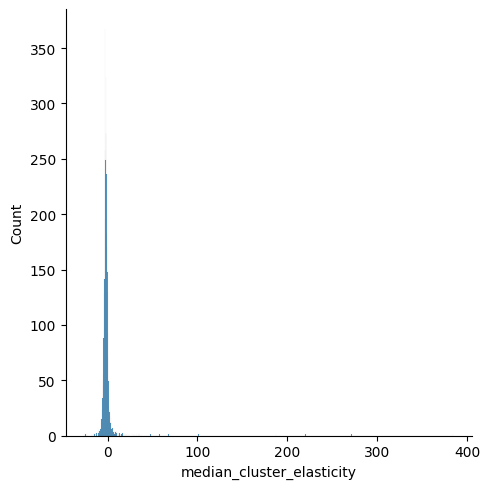

In [335]:
sns.displot(data=x, x="median_cluster_elasticity")
# plt.xlim(-25, 25)

In [337]:
# x["mean_cluster_elasticity"].describe()
df[df["median_cluster_elasticity"]>100]

,region,entity_id,country_code,master_asa_id,asa_common_name,is_asa_clustered,vendor_count_caught_by_asa,fee,tier_rank_master_asa,num_tiers_master_asa,...,previous_order_count_vendor_cluster_tt_fee_level,tier_elasticity_vendor_cluster_level,q25,q75,iqr,lower_bound,upper_bound,is_elasticity_remove,median_cluster_elasticity,mean_cluster_elasticity
29832,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,31.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29833,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,39.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29834,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,47.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29835,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,55.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29836,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,63.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29837,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,71.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29838,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,79.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29839,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,87.00,<NA>,<NA>,...,0,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29840,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,17.00,1,3,...,<NA>,NaN,104.750000,335.249999,230.500000,-241.000000,680.999999,True,220.000000,220.000000
29841,Asia,FP_TH,th,1428,SHOPS - Convenience - Cities (21) - Ubon ratch...,False,9,21.00,2,3,...,1,450.499999,104.750000,335.249999,230.500000,-241.000000,680.999999,False,220.000000,220.000000
